# Task 6.
1. Сделайте свою реализацию U-Net на TensorFlow
2. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
import keras.backend as K

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

# Getting Data

In [3]:
base_directory = '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [4]:
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [16]:
img_dim = 256
batch = 32

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.3)

train_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = batch,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = batch,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = batch,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = batch,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 3576 images belonging to 1 classes.
Found 3576 images belonging to 1 classes.
Found 1532 images belonging to 1 classes.
Found 1532 images belonging to 1 classes.


In [18]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

# Visualization

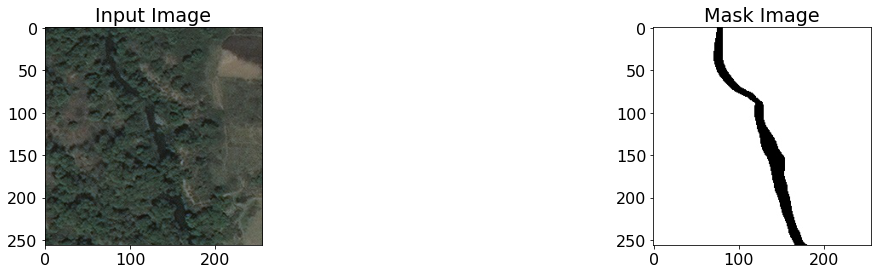

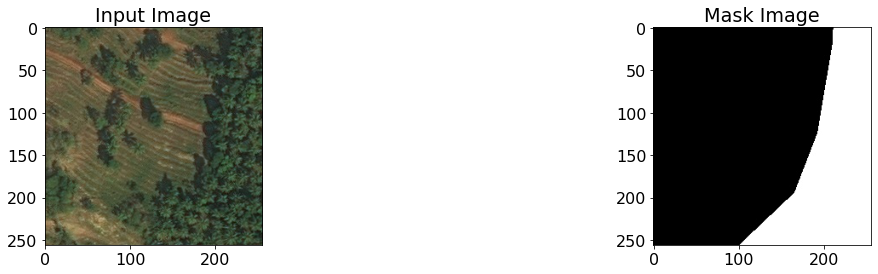

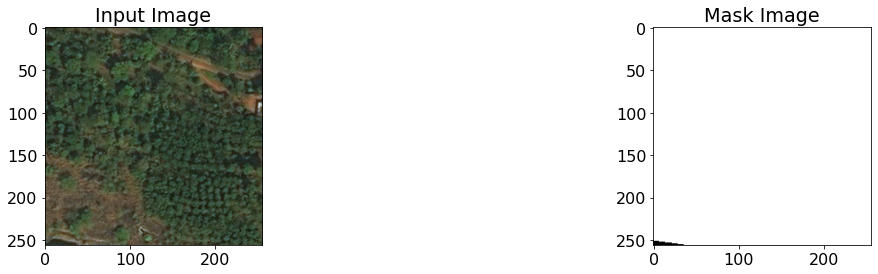

In [7]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 3:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

# Model Architecture + Metrics

In [8]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, 3, padding="same")(input)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)

    conv = Conv2D(num_filters, 3, padding="same")(conv)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)

    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def build_unet(input_shape):
    inputs = Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 32)
    skip2, pool2 = encoder_block(pool1, 64)
    skip3, pool3 = encoder_block(pool2, 128)
    skip4, pool4 = encoder_block(pool3, 256)

    botle_neck = conv_block(pool4, 512)

    decode1 = decoder_block(botle_neck, skip4, 256)
    decode2 = decoder_block(decode1, skip3, 128)
    decode3 = decoder_block(decode2, skip2, 64)
    decode4 = decoder_block(decode3, skip1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [9]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

# Model Training

In [10]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr =1.0e-3), loss = [bce_dice_loss, 'binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model_path = "unet.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

red_lr = ReduceLROnPlateau(monitor = 'val_loss',factor= 0.1, patience = 7)

In [27]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//batch,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//batch,
                    epochs=2, callbacks=[earlystop, checkpoint,red_lr])

Epoch 1/2
111/111 [==============================] - 4055s 37s/step - loss: 0.6674 - iou_coef: 0.5856 - accuracy: 0.7911 - val_loss: 0.9890 - val_iou_coef: 0.4317 - val_accuracy: 0.7399

Epoch 00001: val_loss improved from 5.49470 to 0.98895, saving model to unet.h5
Epoch 2/2
111/111 [==============================] - 4046s 36s/step - loss: 0.6370 - iou_coef: 0.5971 - accuracy: 0.8002 - val_loss: 2.0725 - val_iou_coef: 0.2773 - val_accuracy: 0.5911

Epoch 00002: val_loss did not improve from 0.98895


# Inferencing

In [21]:
import seaborn as sns
sns.set_style('dark')

## Learning Curve

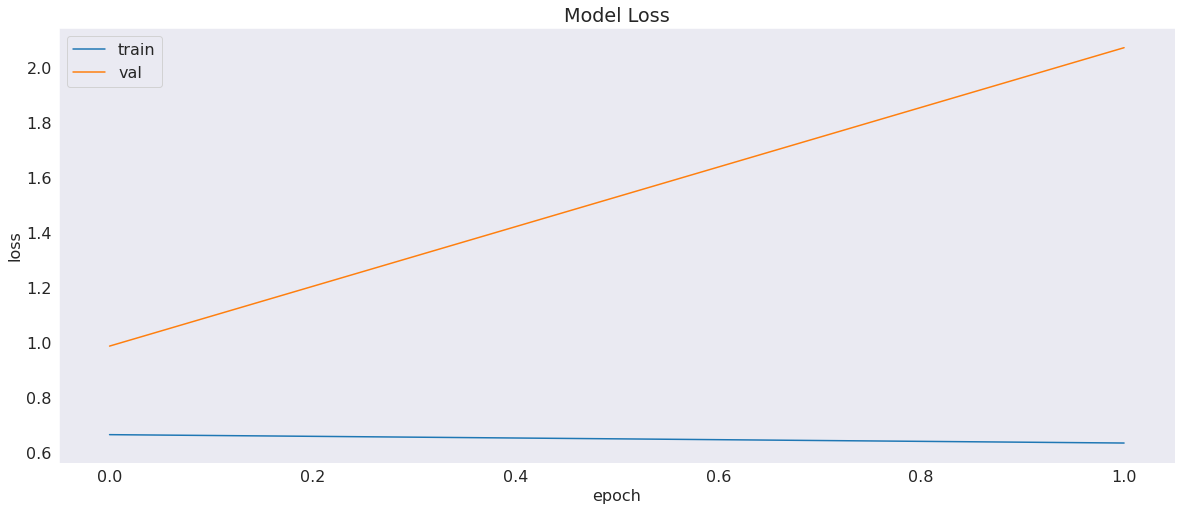

In [28]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

## Ground Truth Masks vs Predicted Masks

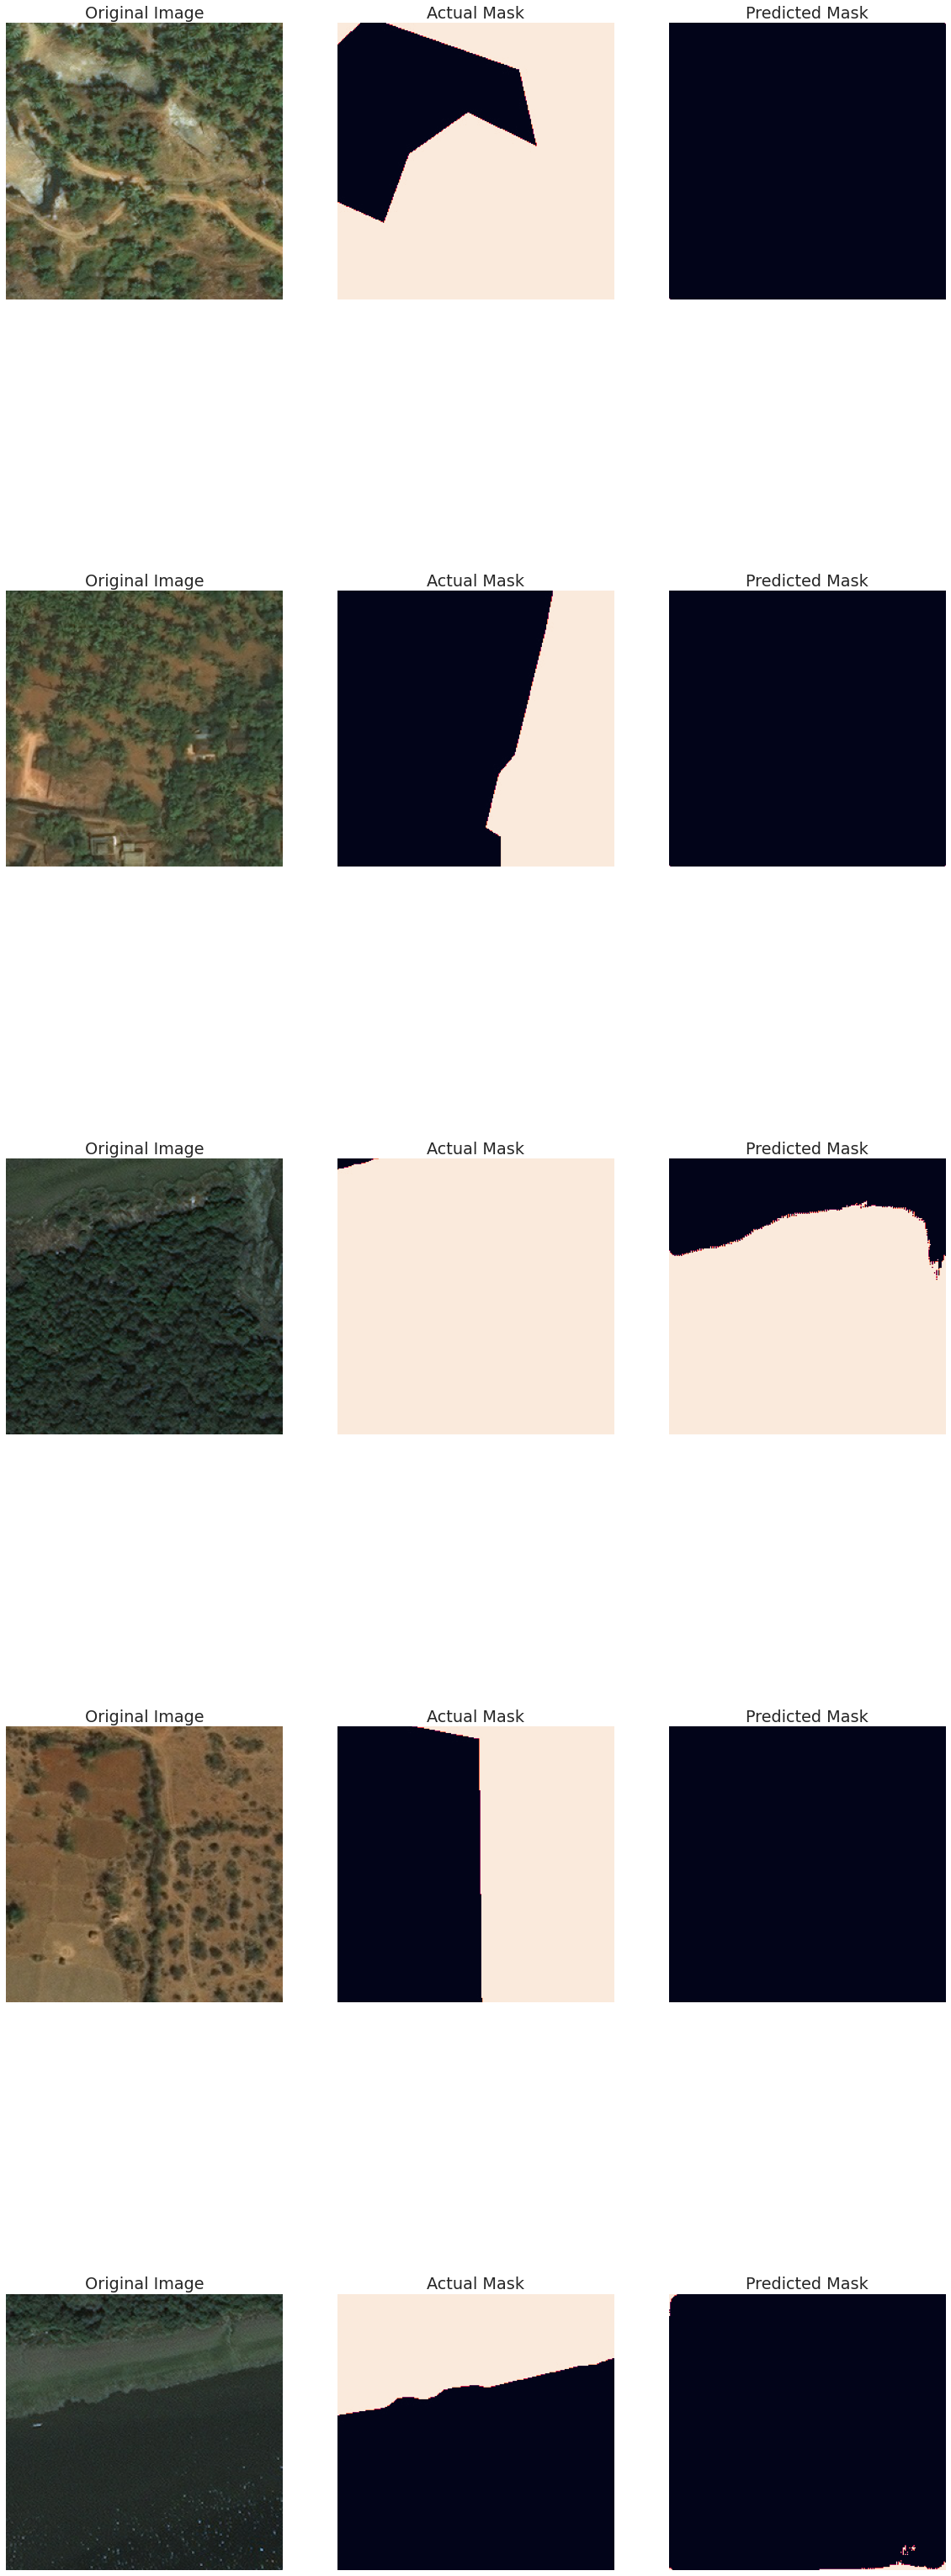

In [24]:
f, axarr = plt.subplots(5,3,figsize=(20, 60))

for i in range(0,5):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_masks[i])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')